# Notebook to develop and try new ideas for figures and analysis

In [1]:
import os, sys, copy
sys.path.append('..')

import dask.dataframe as dd
from codebase.utils import *
from codebase.figures import *
from codebase.metrics import *
from codebase.params import *

import pandas as pd
import xarray as xr
from scipy import stats

from pyproj import Transformer

import seaborn as sns

In [2]:
site_code = 'GPHT'

data_dir = DOWNLOAD_DIR_ROOT + site_code + '/'+ '*.tif'
obs = xr.open_dataset(OBS_PREFIX+site_code+'_obs.nc')

aoi_list = [site_code]
times = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex([i for i in obs.data_vars][:-1])]

In [3]:
obs = xr.open_dataset(OBS_PREFIX+site_code+'_obs.nc')
obs

<xarray.Dataset>
Dimensions:      (y: 3737, x: 2439, band: 7)
Coordinates:
  * y            (y) float64 2.15e+06 2.15e+06 2.15e+06 ... 2.132e+06 2.132e+06
  * x            (x) float64 7.333e+05 7.333e+05 ... 7.455e+05 7.455e+05
  * band         (band) int32 1 2 3 4 5 6 7
Data variables: (12/74)
    01-15-2010   (band, y, x) float32 ...
    01-23-2010   (band, y, x) float32 ...
    01-28-2010   (band, y, x) float32 ...
    02-02-2010   (band, y, x) float32 ...
    04-05-2010   (band, y, x) float32 ...
    05-08-2010   (band, y, x) float32 ...
    ...           ...
    12-30-2018   (band, y, x) float32 ...
    12-27-2019   (band, y, x) float32 ...
    01-11-2020   (band, y, x) float32 ...
    01-20-2020   (band, y, x) float32 ...
    02-12-2020   (band, y, x) float32 ...
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [4]:
ds = xr.open_dataset(CLASSIFIED_PREFIX+site_code+'_classified.nc')
ds

<xarray.Dataset>
Dimensions:   (y: 3737, x: 2439, time: 73)
Coordinates:
  * y         (y) float64 2.15e+06 2.15e+06 2.15e+06 ... 2.132e+06 2.132e+06
  * x         (x) float64 7.333e+05 7.333e+05 7.333e+05 ... 7.455e+05 7.455e+05
  * time      (time) object '01-15-2010' '01-23-2010' ... '02-12-2020'
Data variables:
    water     (time, y, x) bool ...
    mangrove  (time, y, x) bool ...
    mudflat   (time, y, x) bool ...
    crop      (time, y, x) bool ...
    urban     (time, y, x) bool ...
Attributes:
    description:  Classified categories for each observation time

In [5]:
%%time
obs_masked = xr.map_blocks(mask_dataset, obs, [ds])
obs_masked

CPU times: user 10 s, sys: 11.2 s, total: 21.3 s
Wall time: 21.3 s


<xarray.Dataset>
Dimensions:      (band: 7, y: 3737, x: 2439)
Coordinates:
  * y            (y) float64 2.15e+06 2.15e+06 2.15e+06 ... 2.132e+06 2.132e+06
  * x            (x) float64 7.333e+05 7.333e+05 ... 7.455e+05 7.455e+05
  * band         (band) int32 1 2 3 4 5 6 7
    time         <U10 '01-15-2010'
Data variables: (12/74)
    01-15-2010   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    01-23-2010   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    01-28-2010   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    02-02-2010   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    04-05-2010   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    05-08-2010   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    ...           ...
    12-30-2018   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    12-27-2019   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    01-11-2020   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    01-20-2020   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    02-12-2020   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    spatial_ref  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

MovieWriter ffmpeg unavailable; using Pillow instead.


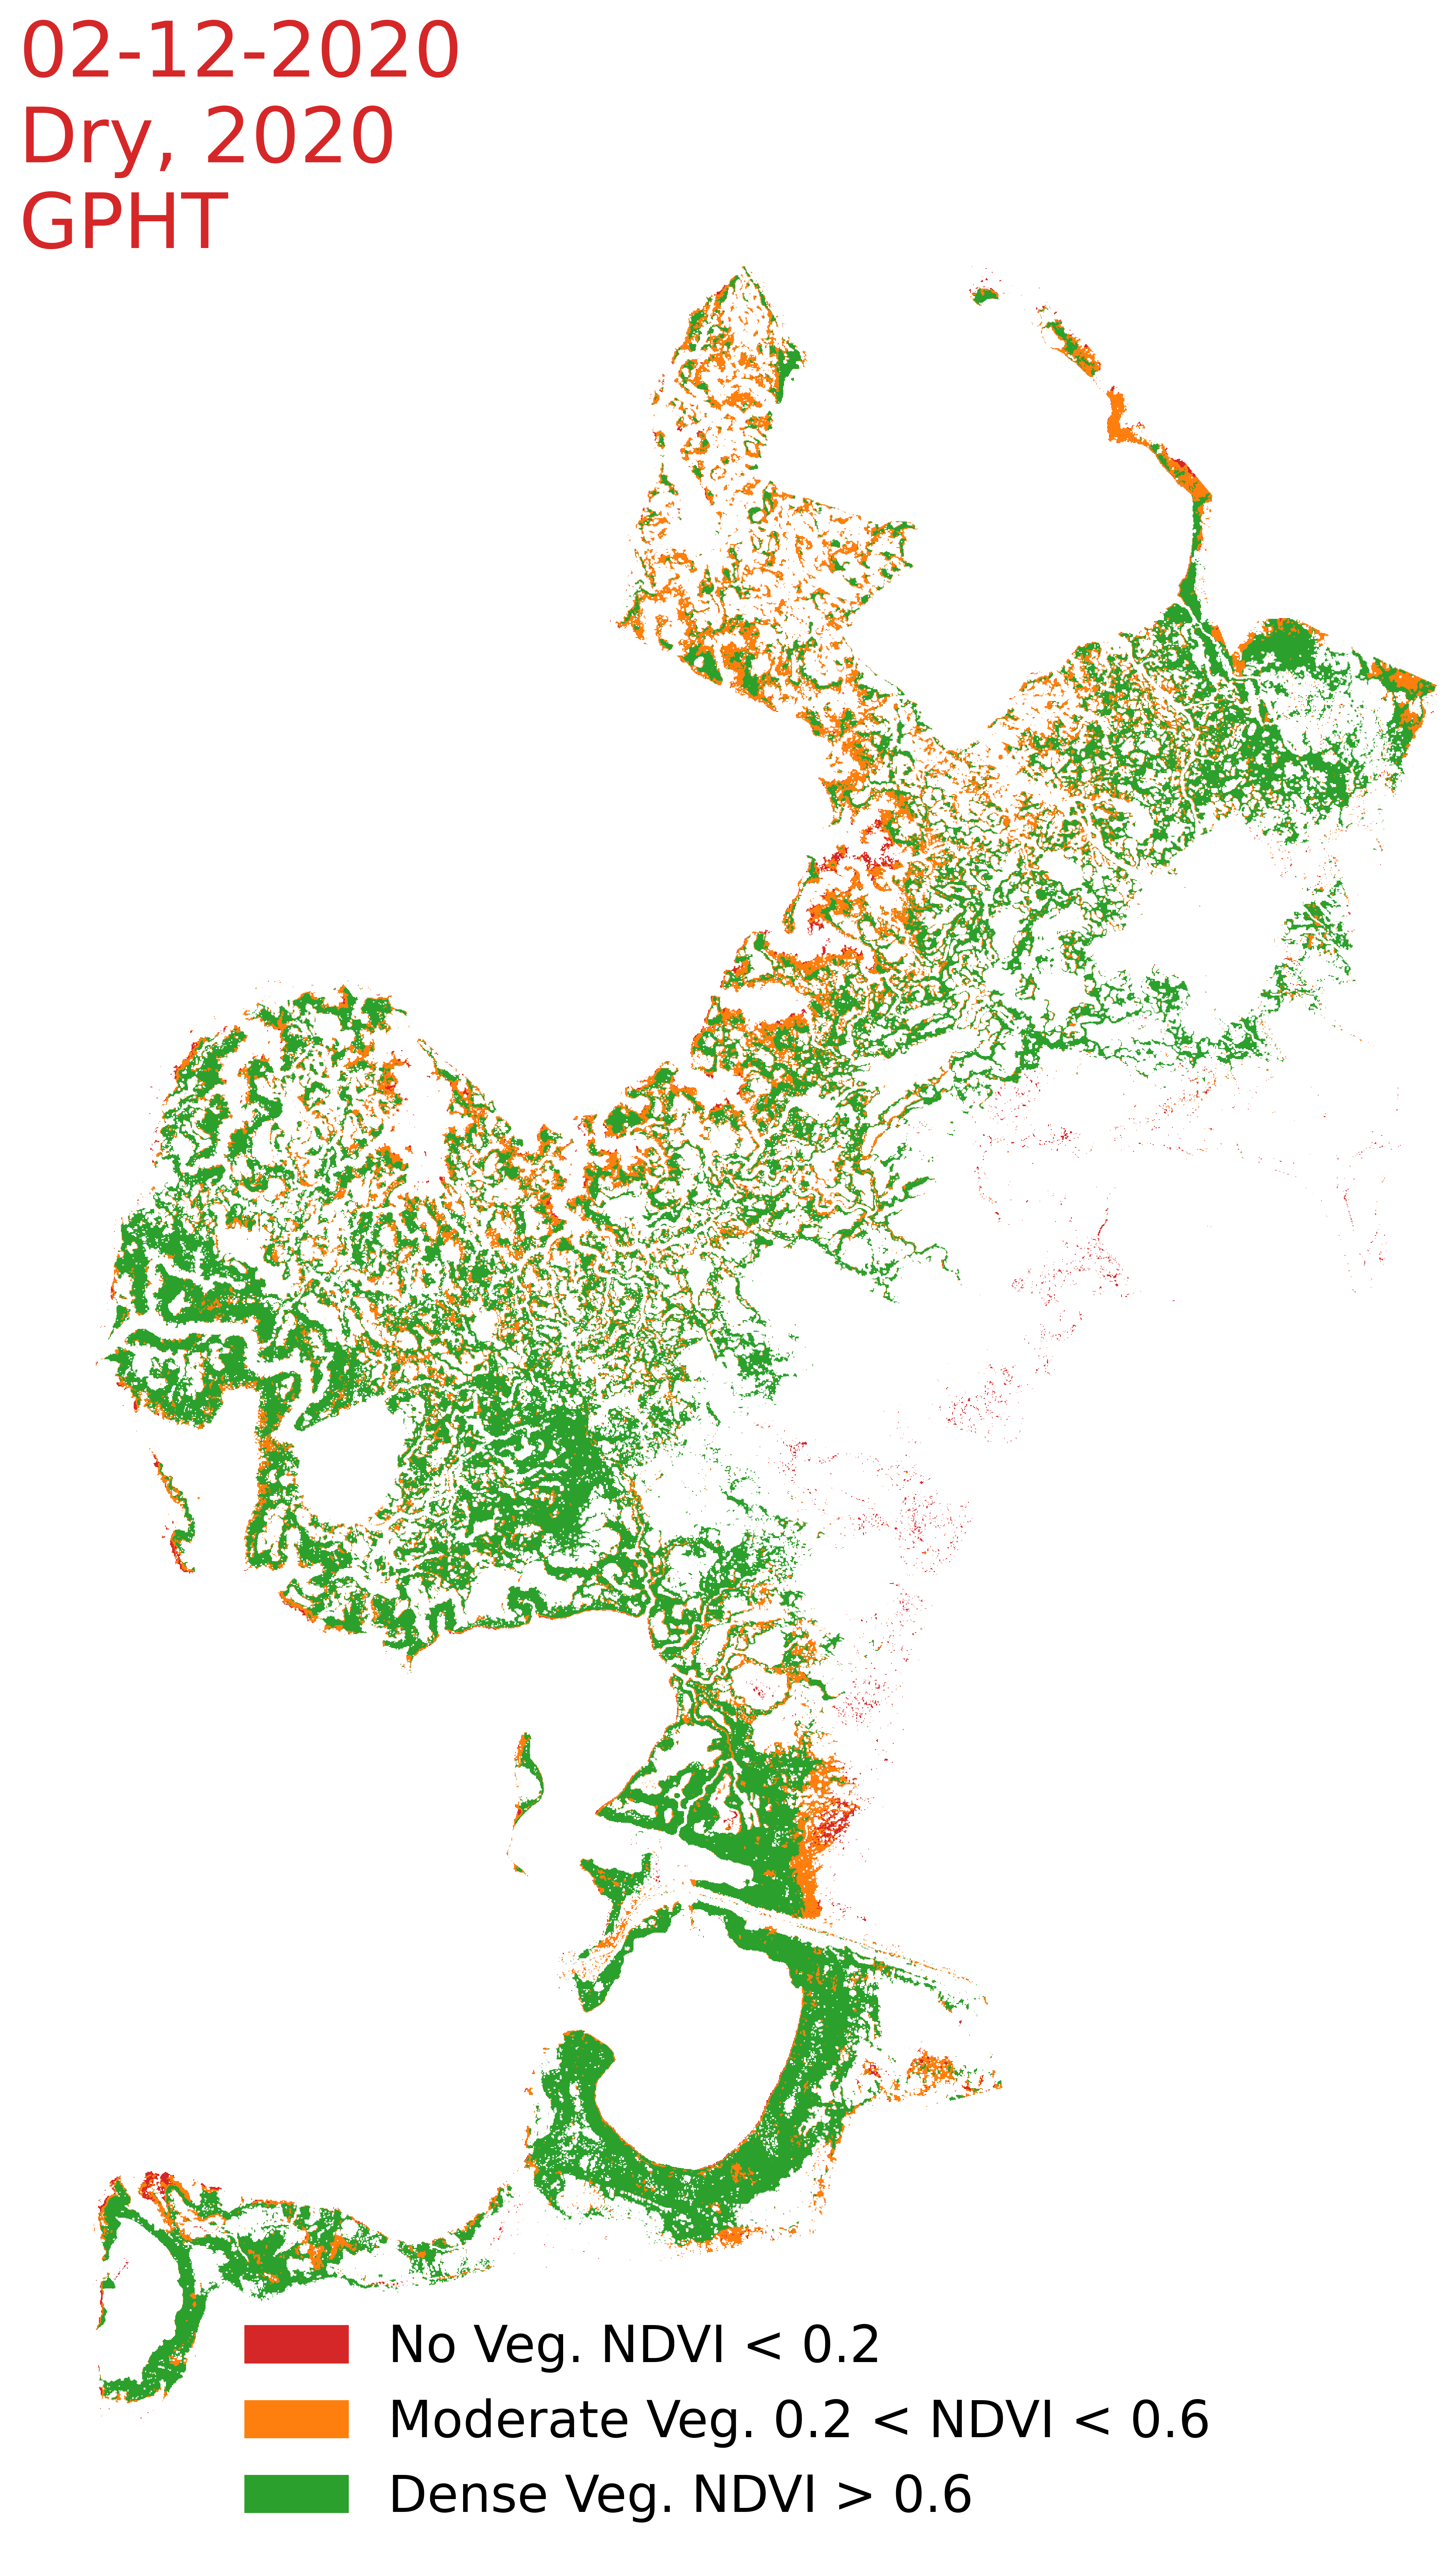

In [7]:
animate_ndvi_maps(obs_masked, times, site_code)

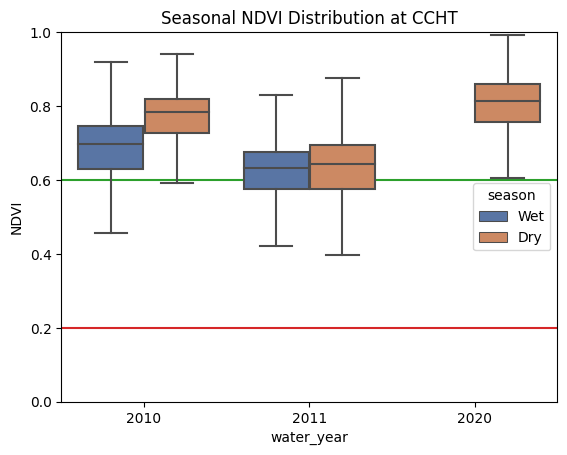

In [8]:
data_box = data_prep_box(obs_masked, times)
plot_box(data_box, site_code)

In [ ]:
data = data_prep(obs_masked, times)
data['NDVI'] = data['NDVI'].apply(clean_df)
data['Mean'] = data['NDVI'].apply(np.mean)
data['Median'] = data['NDVI'].apply(np.median)
data['Stdev'] = data['NDVI'].apply(np.std)
data['Min'] = data['NDVI'].apply(np.min)
data['Max'] = data['NDVI'].apply(np.max)
data['Var'] = data['NDVI'].apply(np.var)
data

In [ ]:
from scipy import stats
from sklearn.linear_model import LinearRegression

def get_conf_int(alpha, lr, X, y):
    
    """
    Returns (1-alpha) 2-sided confidence intervals
    for sklearn.LinearRegression coefficients
    as a pandas DataFrame
    """
    
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, 'const', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'lower': coefs - gap, 'upper': coefs + gap
    }, index=X_aux.columns)


def linear_fit(df, site):
    # Training data
    X = df.loc[:, ['days_from_start']]  # features
    y = df.loc[:, site]  # target

    # Train the model
    model = LinearRegression()
    model.fit(X, y)

    # Store the fitted values as a time series with the same time index as
    # the training data
    y_pred = pd.Series(model.predict(X), index=X.index)

    # Confidence interval
    
    # for 95% confidence interval; use 0.01 for 99%-CI.
    alpha = 0.05
    # fit a sklearn LinearRegression model
    ci = get_conf_int(alpha, model, X, y)


    return y_pred, ci

In [ ]:
def ndvi_calc(times, split_sites, aoi_list):
    avg_NDVI = []
    df = pd.DataFrame(columns=aoi_list)
    for i,site in enumerate(split_sites):
        avg = [site[time][-1].median().values for time in times]
        std = [site[time][-1].std().values for time in times]
        
        avg_NDVI.append(avg)
        df[aoi_list[i]] = avg
        df[aoi_list[i]+' Std'] = std
        
    df['dates'] = [datetime.strptime(date, '%m-%d-%Y').date() for date in times] 
    return df 

In [ ]:
df_NDVI = ndvi_calc(times, [obs], aoi_list)

In [ ]:
df_NDVI

In [ ]:
df_NDVI['days_from_start'] = (df_NDVI['dates'] - df_NDVI['dates'][0]).dt.days

df_NDVI['linfit'] = linear_fit(df_NDVI, site_code)[0]
# Interpolate missing date values for fit without drought points
df_NDVI['dates'] = pd.to_datetime(df_NDVI['dates'])

dates_backup = copy.deepcopy(df_NDVI['dates'].values)


df_NDVI.set_index('dates', inplace=True)
df_NDVI['linfit'] = df_NDVI['linfit'].interpolate(method='time')

df_NDVI['ndates'] = dates_backup
df_NDVI.head()

In [ ]:
def metrics_timeseries(df, site_code, title, ylabel):
    """ Plot the timeseries of specified health metric.
    
    df -- pandas Dataframe of metric to be plotted.
    Columns are, in order:
        datetimeindex, sitecode, ndates, timedelta, linfit
    site_code -- string name of site
    title -- string title of plot
    ylabel -- string y axis label
    """
    fig, ax = plt.subplots(figsize=(16,8))
    
    df_wet = df[(df['ndates'].dt.month >= 5) & (df['ndates'].dt.month <= 10)]
    df_dry = df[~((df['ndates'].dt.month >= 5) & (df['ndates'].dt.month <= 10))]
    
    df_wet.plot.scatter(x='ndates', y=site_code, ax=ax, c='tab:blue', marker='+', s=5, lw=7, zorder=0)
    df_dry.plot.scatter(x='ndates', y=site_code, ax=ax, c='tab:orange', marker='+', s=5, lw=7, zorder=0)
    
    df.plot(x='ndates', y='linfit', ax=ax, c='tab:blue', lw=3, alpha=0.2, label='Linear Fit', zorder=10)

    y_mean_wet = (df_wet[site_code].values).astype('float')
    y_std_wet = (df_wet[site_code + ' Std'].values).astype('float')
    y_mean_dry = (df_dry[site_code].values).astype('float')
    y_std_dry = (df_dry[site_code + ' Std'].values).astype('float')

    #plt.errorbar(df_wet['ndates'].values, y_mean_wet, yerr=y_std_wet, fmt='.', alpha=0.8, c='tab:blue', label='Standard Deviation')
    #plt.errorbar(df_dry['ndates'].values, y_mean_dry, yerr=y_std_dry, fmt='.', alpha=0.8, c='tab:orange', label='Standard Deviation')
    
    
    ax.set_xlim(df['ndates'].min() - timedelta(days=20), df['ndates'].max() + timedelta(days=100))
    ax.set_ylim(0.2, 1.0)
    
    ax.set_title(title)
    ax.set_xlabel('Observation Date')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(zorder=0)

    # careful with saving to not overwrite old plots, leave this commented by default
    plt.savefig('../outputs/Final Figures/new_ndvi_'+site_code+'.png', dpi=800, bbox_inches='tight', transparent=True)

    plt.show();

In [ ]:
metrics_timeseries(df_NDVI, site_code, 'NDVI Timeseries', 'NDVI')